In [5]:
"""Establish a connection BOTH with:
 - Vna
 - DC generator (sim)
 - AC generator (sma) 
"""

from vna import *
IP = "192.168.3.51"
timeout = 25e5
max_npoints = 2e3
vna_instr = ManageVNA(IP,timeout,max_npoints)

from sma import *
resource = 'TCPIP0::192.168.3.2::INSTR'
sma_instr = ManageSMA(resource)


In [7]:
import numpy as np
import h5py
from h5utils import *
from many_instruments import *

MISURA AL VARIARE DELLA POTENZA DEL VNA

In [3]:
"""SETTING PARAMETERS FOR VNA"""
vna_freq_start = 8.5745e9
vna_freq_stop = 8.5745e9
n_vna_pows = 3
vna_pows = np.linspace(-20,-30,n_vna_pows) #dBm
npoints = 40
navgs = 1

In [4]:
vna_pows

array([-20., -25., -30.])

In [5]:
"""SETTING PARAMETERS FOR SMA"""
pows = np.array([-50]) #[dBm] array of power values
fmin_sma = 6.2e9
fmax_sma = 6.4e9
df = 1e6
#nfreqs = round((fmax_sma-fmin_sma)/df)
nfreqs = 200
freqs = np.linspace(fmin_sma,fmax_sma,nfreqs)
sma_instr.set_amplitude(pows[0])
sma_instr.set_output(1)

In [6]:
vna_instr.set_IFBW(10)

In [7]:
"""PREPARE THE H5 FILE"""
filename="misura_variaVNA_12_06.h5"
#filename="measure_exitation_9_06_VNA-20dBm_1MHzVNARange.h5"

In [8]:
"""CYCLE MEASURE"""
sma_instr.set_output(1)
for vna_pow in vna_pows:
    #Save simulation parameters in a dataset 'parameters'
    group="VNA_power"+str(round(vna_pow,3))+"dBm"
    sma_instr.set_amplitude(pows[0])
    name_array = ["sma_pow","vna_pow","vna_freq_start","vna_freq_stop","fmin_sma","fmax_sma","nfreqs","npoints"]
    value_array = [str(pows[0]),str(vna_pow),str(vna_freq_start),str(vna_freq_stop),str(fmin_sma),str(fmax_sma),str(nfreqs),str(npoints)]
    hf = h5py.File(filename, 'a')
    mat = [name_array, value_array]
    hf.create_dataset(group+"/parameters", data = mat)
    hf.close()
    #Perform the sampling
    gain_average = np.zeros(nfreqs)
    gain_std = np.zeros(nfreqs)
    phase_average = np.zeros(nfreqs)
    phase_std = np.zeros(nfreqs)
    for i in np.arange(0,nfreqs):
        #print("A")
        sma_instr.set_freq(round(freqs[i],3))
        f, I, Q = vna_instr.single_scan(vna_freq_start,vna_freq_stop,vna_pow,npoints,navgs)
        # S21dB = 20*np.log10(np.sqrt(np.multiply(I,I)+np.multiply(Q,Q)))
        # phase = np.arctan2(Q,I)
        # gain_average[i] = np.mean(S21dB)
        # gain_std[i] = np.mean(S21dB)
        # phase_average[i] = np.mean(phase)
        # phase_std[i] = np.mean(phase)
        # mat = [gain_average,gain_std,phase_average,phase_std]
        # hf.create_dataset(group+"/drive_freq"+str(i), data = mat)
        mat = [f,I,Q]        
        hf = h5py.File(filename, 'a')
        hf.create_dataset(group+"/drive_freq"+str(i), data = mat)
        hf.close()
    print(vna_pow)

sma_instr.set_output(0)

-20.0
-25.0
-30.0


ANALISI MISURE FISSATO SMA(-50dBm) E VARIANDO VNA(-20,-25,-30)

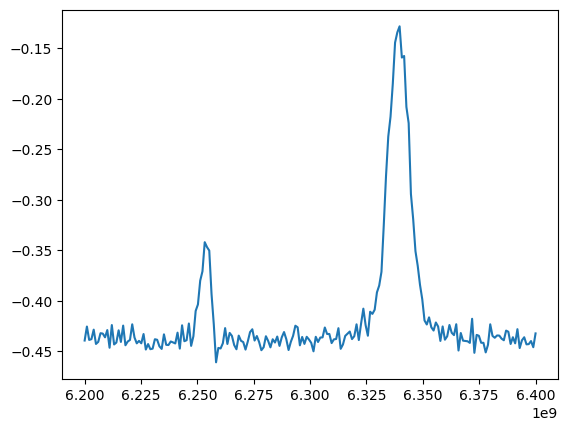

In [25]:
filename = "misura_variaVNA_12_06.h5"
group = "/VNA_power-30.0dBm"
datasets = getDatasets(filename,group,0)
hf = h5py.File(filename, 'r')
hfg = hf[group]

params_names, params_values = getDatasetValue(filename,group,-1)
nfreqs=int(params_values[6])
freq_min=float(params_values[4])
freq_max=float(params_values[5])

frequenza=np.linspace(freq_min,freq_max,nfreqs)

#params_names

gain_average = np.zeros(nfreqs)
gain_std = np.zeros(nfreqs)
phase_average = np.zeros(nfreqs)
phase_std = np.zeros(nfreqs)

for i in np.arange(0,nfreqs):
    dataset_mat = hfg.get( "drive_freq"+str(i))
    f = dataset_mat[0]
    I = dataset_mat[1] 
    Q = dataset_mat[2]
    S21dB = 20*np.log10(np.sqrt(np.multiply(I,I)+np.multiply(Q,Q)))
    phase = np.arctan2(Q,I)
    gain_average[i] = np.mean(S21dB)
    gain_std[i] = np.mean(S21dB)
    phase_average[i] = np.mean(phase)
    phase_std[i] = np.mean(phase)
    mat = [gain_average,gain_std,phase_average,phase_std]
hf.close()



plt.plot(frequenza,phase_average)


In [15]:
params_names

array([b'sma_pow', b'vna_pow', b'vna_freq_start', b'vna_freq_stop',
       b'fmin_sma', b'fmax_sma', b'nfreqs', b'npoints'], dtype=object)

MISURA CURVE CHE LORO HANNO GIA TROVATO COI LORO PARAMETRI per -20, -50dBm

In [9]:
"""SETTING PARAMETERS FOR VNA"""
vna_freq_start = 8.5745e9
vna_freq_stop = 8.5745e9
vna_pow = -25 #dBm
npoints = 40
navgs = 1

In [13]:
np.linspace(-50,-30,9)

array([-50. , -47.5, -45. , -42.5, -40. , -37.5, -35. , -32.5, -30. ])

In [10]:
"""SETTING PARAMETERS FOR SMA"""
pows = np.array(-47.5, -45, -42.5, -40, -37.5, -35, -32.5) #[dBm] array of power values
fmin_sma = 6e9
fmax_sma = 6.8e9
#df = 1e6
#nfreqs = round((fmax_sma-fmin_sma)/df)
nfreqs = 800
freqs = np.linspace(fmin_sma,fmax_sma,nfreqs)
sma_instr.set_amplitude(pows[0])
sma_instr.set_output(1)

In [11]:
"""PREPARE THE H5 FILE"""
#filename="test_9_06.h5"
filename="misura_variaSMA_12_06.h5"

In [12]:
"""CYCLE MEASURE"""
sma_instr.set_output(1)
for sma_pow in pows:
    #Save simulation parameters in a dataset 'parameters'
    group="SMA_power"+str(round(sma_pow,2))+"dBm"
    sma_instr.set_amplitude(sma_pow) 
    name_array = ["sma_pow","vna_pow","vna_freq_start","vna_freq_stop","fmin_sma","fmax_sma","nfreqs","npoints"]
    value_array = [str(sma_pow),str(vna_pow),str(vna_freq_start),str(vna_freq_stop),str(fmin_sma),str(fmax_sma),str(nfreqs),str(npoints)]
    hf = h5py.File(filename, 'a')
    mat = [name_array, value_array]
    hf.create_dataset(group+"/parameters", data = mat)
    hf.close()
    #Perform the sampling
    #gain_average = np.zeros(nfreqs)
    #gain_std = np.zeros(nfreqs)
    for i in np.arange(0,nfreqs):
        sma_instr.set_freq(round(freqs[i],3))
        f, I, Q = vna_instr.single_scan(vna_freq_start,vna_freq_stop,vna_pow,npoints,navgs)
        hf = h5py.File(filename, 'a')
        mat = [f,I,Q]
        hf.create_dataset(group+"/drive_freq"+str(i), data = mat)
        hf.close()
        #gain_average[i] = np.mean(S21)
        #gain_std[i] = np.std(S21)
        #print(gain_average[i])
    print(sma_pow)

sma_instr.set_output(0)

-20
-50


LETTURA

In [13]:
# """GET PARAMS"""
# vna_pow = -22.222 #[dBm]
# params_names, params_values = getDatasetValue(filename,"/VNA_power"+str(vna_pow)+"dBm/",-1)

# # Print [Check if the order of paramerers is the same of the assegnation below!]
# for i in np.arange(0,len(params_names)):
#     print(str(params_names[i].decode("utf-8")),": ",str(params_values[i].decode("utf-8")))

# # Vna
# powerdBm = float(params_values[1]) #[dBm]
# npts = int(params_values[7])
# vna_freq_start = float(params_values[2])
# vna_freq_stop = float(params_values[3])
# # Sma
# freq_start = float(params_values[4])/1e9 #[GHz]
# freq_stop = float(params_values[5])/1e9 #[Ghz]
# n_freq = int(params_values[6])

# freqs = np.linspace(freq_start, freq_stop, n_freq) 
# vna_freqs = np.linspace(vna_freq_start, vna_freq_stop, npts)

KeyError: "Unable to open object (object 'VNA_power-22.222dBm' doesn't exist)"

ANALISI VARIA SMA POW

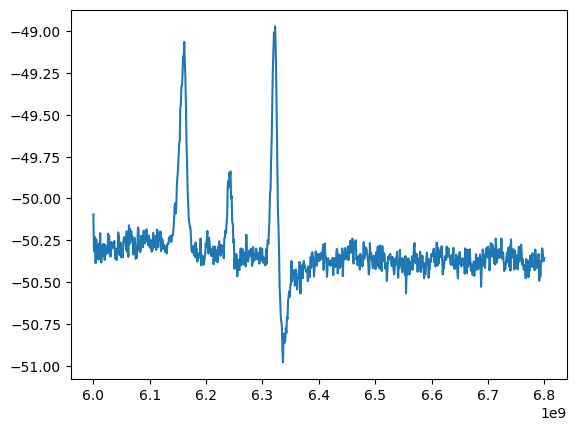

In [31]:
filename="misura_variaSMA_12_06.h5"
group = "/SMA_power-50dBm"
datasets = getDatasets(filename,group,0)
hf = h5py.File(filename, 'r')
hfg = hf[group]

params_names, params_values = getDatasetValue(filename,group,-1)
nfreqs=int(params_values[6])
freq_min=float(params_values[4])
freq_max=float(params_values[5])

frequenza=np.linspace(freq_min,freq_max,nfreqs)

#params_names

gain_average = np.zeros(nfreqs)
gain_std = np.zeros(nfreqs)
phase_average = np.zeros(nfreqs)
phase_std = np.zeros(nfreqs)

for i in np.arange(0,nfreqs):
    dataset_mat = hfg.get( "drive_freq"+str(i))
    f = dataset_mat[0]
    I = dataset_mat[1] 
    Q = dataset_mat[2]
    S21dB = 20*np.log10(np.sqrt(np.multiply(I,I)+np.multiply(Q,Q)))
    phase = np.arctan2(Q,I)
    gain_average[i] = np.mean(S21dB)
    gain_std[i] = np.mean(S21dB)
    phase_average[i] = np.mean(phase)
    phase_std[i] = np.mean(phase)
    mat = [gain_average,gain_std,phase_average,phase_std]
hf.close()



plt.plot(frequenza,gain_average)


In [9]:
"""MEASURE PHASE DRIVE ON OFF IN ORDER TO FIND DISCRIMINANT FREQ"""
vna_freq_start = 8.573e9
vna_freq_stop = 8.576e9
vna_pow = -25
npoints = 1601
navgs = 1
vna_instr.set_IFBW(10)

filename = "13_06_discriminant_freq.h5"

# Off
sma_instr.set_output(0)
f, I, Q = vna_instr.single_scan(vna_freq_start,vna_freq_stop,vna_pow,npoints,navgs)
hf = h5py.File(filename, 'a')
mat = [f,I,Q]
hf.create_dataset("/no_drive", data = mat)
hf.close()
# On
sma_instr.set_output(1)
sma_instr.set_freq(6.32e9)
sma_instr.set_amplitude(-50)
f, I, Q = vna_instr.single_scan(vna_freq_start,vna_freq_stop,vna_pow,npoints,navgs)
hf = h5py.File(filename, 'a')
mat = [f,I,Q]
hf.create_dataset("/drive_-50dBm_6-32GHz", data = mat)
hf.close()

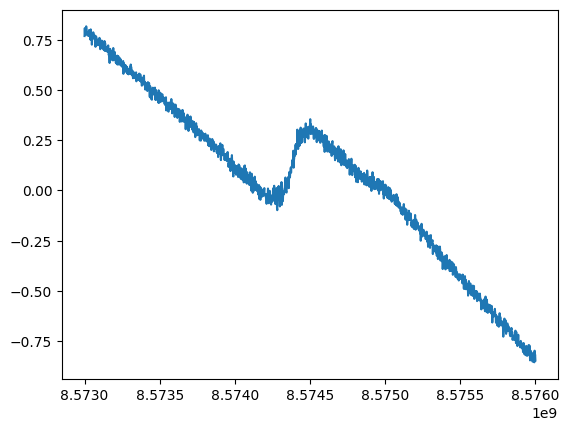

In [12]:
S21dB = 20*np.log10(np.sqrt(np.multiply(I,I)+np.multiply(Q,Q)))
phase = np.arctan2(Q,I)
plt.plot(f,phase)

In [4]:
f, I, Q = vna_instr.single_scan(vna_freq_start,vna_freq_stop,vna_pow,2,navgs)

In [ ]:
"""Plot (and get) a specific measure AND Fit"""
vna_pow = -22.222


group = "/VNA_power"+str(vna_pow)+"dBm/"

fmin = 4e9
fmax = 5e9

# Retrieve data from the specified dataset
datasets = getDatasets(filename,group,0)
hf = h5py.File(filename, 'r')
hfg = hf[group]
for f in np.arange(0,nfreqs):
    dataset_mat = hfg.get("drive_freq"+str(f))
    # S21dB = 20*np.log10(np.sqrt(np.multiply(I,I)+np.multiply(Q,Q)))
        # phase = np.arctan2(Q,I)
        # gain_average[i] = np.mean(S21dB)
        # gain_std[i] = np.mean(S21dB)
        # phase_average[i] = np.mean(phase)
        # phase_std[i] = np.mean(phase)
    gain_average = dataset_mat[0]
    gain_std = dataset_mat[1]
    phase_average = dataset_mat[2]
    phase_std = dataset_mat[3]
hf.close()

plt.plot(freqs,gain_average)

In [ ]:
n_vna_pows = 10
vna_pows = np.linspace(-20,-30,n_vna_pows) #dBm
vna_pows

In [ ]:
f, I, Q = vna_instr.single_scan(vna_freq_start,vna_freq_stop,vna_pow,npoints,navgs)

In [ ]:
xs, ys = getDatasetValue(filename,group,dataset_index)

PIU RISOLUTO! 13h

In [ ]:
"""PREPARE THE H5 FILE"""
filename="measure_exitation_8_06_MOLTOLUNGO.h5"

In [ ]:
"""SETTING PARAMETERS FOR SMA"""
pows = np.array([-50,-40,-30,-20]) #[dBm] array of power values
fmin_sma = 6e9
fmax_sma = 6.8e9
df = 0.1e6
nfreqs = round((fmax_sma-fmin_sma)/df)
freqs = np.linspace(fmin_sma,fmax_sma,nfreqs)
sma_instr.set_amplitude(pows[0])
sma_instr.set_output(1)

In [ ]:
"""CYCLE MEASURE"""
for sma_pow in pows:
    #Save simulation parameters in a dataset 'parameters'
    group="SMA_power"+str(round(sma_pow,2))+"dBm" 
    name_array = ["sma_pow","vna_pow","vna_freq","fmin_sma","fmax_sma","nfreqs","npoints"]
    value_array = [str(sma_pow),str(vna_pow),str(vna_freq),str(fmin_sma),str(fmax_sma),str(nfreqs),str(npoints)]
    hf = h5py.File(filename, 'a')
    mat = [name_array, value_array]
    hf.create_dataset(group+"/parameters", data = mat)
    hf.close()
    #Perform the sampling
    gain_average = np.zeros(nfreqs)
    gain_std = np.zeros(nfreqs)
    for i in np.arange(0,nfreqs):
        sma_instr.set_freq(round(freqs[i],3))
        f, S21 = vna_instr.single_scan(vna_freq,vna_freq,vna_pow,npoints,navgs)
        gain_average[i] = np.mean(S21)
        gain_std[i] = np.std(S21)
        #print(gain_average[i])
    hf = h5py.File(filename, 'a')
    mat = [gain_average, gain_std]
    hf.create_dataset(group+"/measure", data = mat)
    hf.close()
    print(sma_pow)

In [ ]:
sma_instr.set_freq(6.3e9)
sma_instr.set_output(1)

In [ ]:
fig, ax = plt.subplots()
ax.plot(freqs/1e9,gain_average,'.',label='data')
ax.set_xlabel('SMA (Drive) frequency [GHz]')
ax.set_ylabel('gain average [dBm]')
ax.set_title("Drive (SMA) power "+str(sma_pow)+"dBm")
ax.legend()

In [ ]:
"""PRINT ALL the dataets or groups in the Selected Group"""
group = "/"
datasets = getDatasets(filename,group)
groups = getGroups(filename,group)